In [220]:
# %python3 -m pip install -r requirements.txt
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon

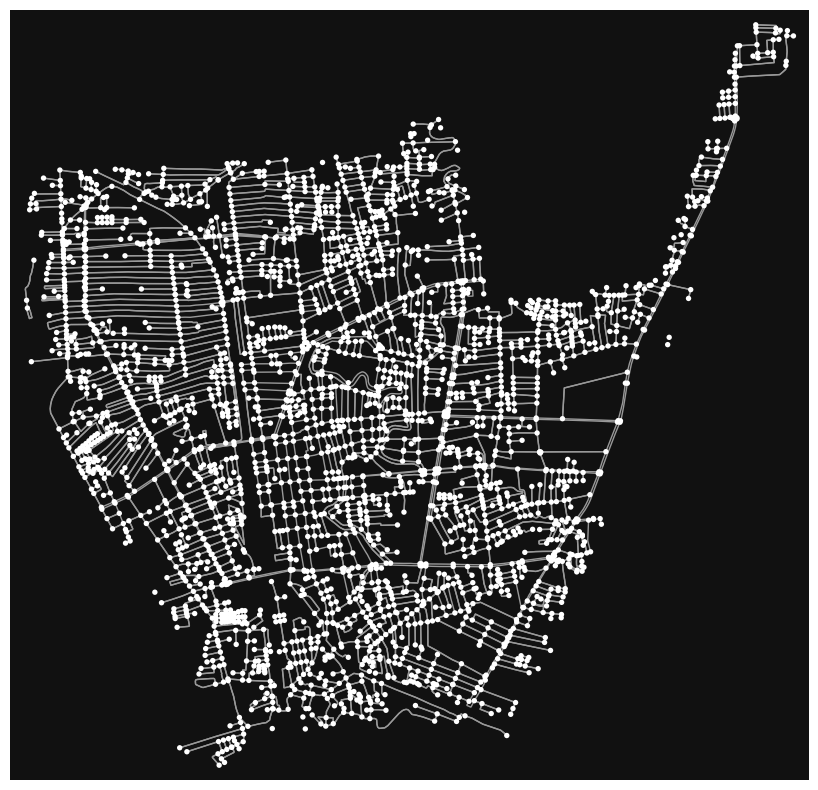

In [221]:
place_name = "Hat Yai District, Songkhla, Thailand"
def load_graph():
    return ox.graph_from_place(place_name, network_type='drive')

# Build full graph from place
graph = load_graph()

# Polygon filter
area_coordinates = [
    (100.502769, 7.037112),
    (100.506839, 7.036403),
    (100.484659, 6.981756),
    (100.483150, 6.987053),
    (100.467264, 6.986236),
    (100.466289, 6.983138),
    (100.461562, 6.984726),
    (100.460087, 6.997991),
    (100.451423, 7.006697),
    (100.450599, 7.022179),
    (100.452207, 7.026726),
    (100.477673, 7.027629),
    (100.478553, 7.030400),
    (100.481593, 7.031277),
    (100.484508, 7.017035),
    (100.496636, 7.018713),
]
polygon = Polygon(area_coordinates)

# Clip graph to polygon
graph_filtered = ox.truncate.truncate_graph_polygon(graph, polygon)

# Plot
fig, ax = ox.plot_graph(graph_filtered, figsize=(12, 10))

In [222]:
edges = ox.graph_to_gdfs(graph_filtered, nodes=False, edges=True)

In [223]:
edges.columns

Index(['osmid', 'highway', 'name', 'oneway', 'reversed', 'length', 'bridge',
       'geometry', 'lanes', 'maxspeed', 'ref', 'junction', 'access', 'tunnel'],
      dtype='object')

In [224]:
# Get nodes and edges as GeoDataFrames
nodes, edges = ox.graph_to_gdfs(graph_filtered)

print(f"Network Statistics:")
print(f"Number of nodes: {len(nodes)}")
print(f"Number of edges: {len(edges)}")
print(f"\nNodes columns: {list(nodes.columns)}")
print(f"\nEdges columns: {list(edges.columns)}")

# Check the bounds of the network
bounds = nodes.total_bounds
print(f"\nNetwork bounds (lon_min, lat_min, lon_max, lat_max): {bounds}")
print(edges['length'])
# Export nodes and edges to CSV files
nodes_csv = nodes.copy()
# Convert geometry to separate lat/lon columns for CSV export
nodes_csv['longitude'] = nodes_csv.geometry.x
nodes_csv['latitude'] = nodes_csv.geometry.y
nodes_csv = nodes_csv.drop('geometry', axis=1)

edges_csv = edges.copy()
# Drop geometry column for CSV export as it's complex
edges_csv = edges_csv.drop('geometry', axis=1)

# Export to CSV
nodes_csv.to_csv('data/raw/road/hatyai_nodes.csv', index=True)
edges_csv.to_csv('data/raw/road/hatyai_edges.csv', index=True)

print(f"\nExported data:")
print(f"Nodes exported to 'hatyai_nodes.csv' ({len(nodes_csv)} records)")
print(f"Edges exported to 'hatyai_edges.csv' ({len(edges_csv)} records)")


Network Statistics:
Number of nodes: 3029
Number of edges: 6999

Nodes columns: ['y', 'x', 'highway', 'street_count', 'junction', 'geometry']

Edges columns: ['osmid', 'highway', 'name', 'oneway', 'reversed', 'length', 'bridge', 'geometry', 'lanes', 'maxspeed', 'ref', 'junction', 'access', 'tunnel']

Network bounds (lon_min, lat_min, lon_max, lat_max): [100.4511039   6.9839845 100.5063432   7.0369187]
u            v            key
485580824    8642774010   0       48.863447
             4900465156   0       52.419118
             12008685153  0      269.444197
             13368519214  0       94.990321
485580829    3307271116   0        7.747836
                                    ...    
13434451561  13434451561  1      292.894345
13437630804  2506092381   0        1.884666
                          1        1.884666
             2506092132   0       43.923334
             2506092371   0       88.701742
Name: length, Length: 6999, dtype: float64

Exported data:
Nodes exported to 'hat

In [225]:
nodes = pd.read_csv('data/raw/road/hatyai_nodes.csv')
edges = pd.read_csv('data/raw/road/hatyai_edges.csv')

In [226]:
# Add edge/node capacities using length and lanes (default lane width 3.5 m)

def add_capacity(nodes_df, edges_df, lane_width=3.5, default_lanes=1):

    edges_df = edges_df.copy()

    nodes_df = nodes_df.copy()

    lanes_numeric = pd.to_numeric(edges_df.get("lanes"), errors="coerce")

    lanes_numeric = lanes_numeric.fillna(default_lanes).clip(lower=default_lanes)

    edges_df["lanes_clean"] = lanes_numeric

    edges_df["capacity"] = edges_df["length"].fillna(0) * lane_width * edges_df["lanes_clean"]

    node_capacity = (

        pd.concat(

            [

                edges_df[["u", "capacity"]].rename(columns={"u": "osmid"}),

                edges_df[["v", "capacity"]].rename(columns={"v": "osmid"}),

            ]

        )

        .groupby("osmid")["capacity"]

        .sum()

        .rename("capacity")

    )

    nodes_df = nodes_df.merge(node_capacity, on="osmid", how="left")

    nodes_df["capacity"] = nodes_df["capacity"].fillna(0)

    return nodes_df, edges_df



nodes, edges = add_capacity(nodes, edges)

nodes.to_csv("data/clean/hatyai_nodes_with_capacity.csv", index=False)

edges.to_csv("data/clean/hatyai_edges_with_capacity.csv", index=False)

print(

    "Capacities added: "

    f"nodes with capacity={len(nodes)}; "

    f"edges with capacity={len(edges)}; "

    f"lane width={3.5}m"

)

Capacities added: nodes with capacity=3029; edges with capacity=6999; lane width=3.5m


In [227]:
# Load shelters from text file and save as GeoDataFrame

def load_shelters(txt_path="data/tmp/โรงเรียนในหาดใหญ่.txt"):

    # Expect lines: name, lat, lon

    shelters = pd.read_csv(

        txt_path,

        header=None,

        names=["name", "lat", "lon"],

        sep=",",

        engine="python",

        skipinitialspace=True,

    )

    shelters["lat"] = shelters["lat"].astype(float)

    shelters["lon"] = shelters["lon"].astype(float)

    shelters_gdf = gpd.GeoDataFrame(

        shelters,

        geometry=gpd.points_from_xy(shelters["lon"], shelters["lat"]),

        crs="EPSG:4326",

    )

    shelters_gdf.to_csv("data/clean/hatyai_shelters.csv", index=False)

    return shelters_gdf



shelters = load_shelters()

print(f"Shelters loaded: {len(shelters)}")

print(shelters.head())

Shelters loaded: 34
                                  name       lat         lon  \
0  โรงเรียนเทศบาล 1 (เอ็งเสียงสามัคคี)  7.016168  100.470097   
1       โรงเรียนเทศบาล 2 (บ้านหาดใหญ่)  7.002162  100.460692   
2      โรงเรียนเทศบาล 4 (วัดคลองเรียน)  6.998946  100.486615   
3        โรงเรียนเทศบาล 5 (วัดหาดใหญ่)  7.003150  100.454090   
4       โรงเรียนเทศบาล 6 (อนุบาลในฝัน)  7.001546  100.459038   

                    geometry  
0   POINT (100.4701 7.01617)  
1  POINT (100.46069 7.00216)  
2  POINT (100.48662 6.99895)  
3  POINT (100.45409 7.00315)  
4  POINT (100.45904 7.00155)  


In [228]:
# Attach shelters onto nearest road nodes

def attach_shelters_to_nodes(nodes_df, shelters_gdf):

    nodes_geo = gpd.GeoDataFrame(

        nodes_df.copy(),

        geometry=gpd.points_from_xy(nodes_df.x, nodes_df.y),

        crs="EPSG:4326",

    )

    nearest = gpd.sjoin_nearest(

        shelters_gdf,

        nodes_geo,

        how="left",

        distance_col="shelter_node_dist_deg",

    )

    grouped = nearest.groupby("index_right").agg(

        shelter_names=("name", lambda s: "; ".join(sorted(set(s.dropna())))),

        shelter_min_dist_deg=("shelter_node_dist_deg", "min"),

    )

    nodes_out = nodes_df.copy()

    nodes_out["is_shelter"] = False

    nodes_out["shelter_names"] = np.nan

    nodes_out["shelter_min_dist_deg"] = np.nan

    nodes_out.loc[grouped.index, "is_shelter"] = True

    nodes_out.loc[grouped.index, "shelter_names"] = grouped["shelter_names"].values

    nodes_out.loc[grouped.index, "shelter_min_dist_deg"] = grouped[

        "shelter_min_dist_deg"

    ].values

    return nodes_out



nodes = attach_shelters_to_nodes(nodes, shelters)

nodes.to_csv("data/clean/hatyai_nodes_with_capacity_and_shelter.csv", index=False)

print("Shelters attached to nodes:", nodes["is_shelter"].sum())

Shelters attached to nodes: 34


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/array.py:417: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
/var/folders/wk/qkt4jd3144lcc_q05d6x6h7m0000gn/T/ipykernel_28703/3516669418.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['โรงเรียนวิริยะเธียรวิทยา' 'โรงเรียนสหศาสตร์วิทยาคาร' 'โรงเรียนพัฒนศึกษา'
 'โรงเรียนเทศบาล 6 (อนุบาลในฝัน)' 'โรงเรียนธรรมศึกษามูลนิธิ'
 'โรงเรียนเทศบาล 2 (บ้านหาดใหญ่)' 'โรงเรียนพลวิทยา'
 'โรงเรียนศรีนครมูลนิธิ' 'โรงเรียนเทศบาล 5 (วัดหาดใหญ่)'
 'โรงเรียนพลวิทยาระบบสองภาษา' 'โรงเรียนนานาชาติอเมริกัน เพรพ'
 'โรงเรียนสุวรรณวงศ์' 'โรงเรียนคุณธรรมวิทยา' 'โรงเรียนสมานคุณวิทยาทาน'
 'โรงเรียนเทพอำนวยหาดใหญ่' 'โรงเรียนทิพรัตน์วิทยาคาร'
 'โรงเรียนธิดานุเคราะห์' 'โรงเรียนอนุบาลกุลจิ

In [229]:
# Randomly allocate population/households across nodes
pop_male = 64864
pop_female = 75987
pop_total = 140851
households = 70703

rng = np.random.default_rng(888)
n = len(nodes)
weights = np.ones(n) / n

nodes["pop_male"] = rng.multinomial(pop_male, weights)
nodes["pop_female"] = rng.multinomial(pop_female, weights)
nodes["pop_total"] = nodes["pop_male"] + nodes["pop_female"]
nodes["households"] = rng.multinomial(households, weights)

print("Population assigned:"
      f" male={nodes['pop_male'].sum()}"
      f" female={nodes['pop_female'].sum()}"
      f" total={nodes['pop_total'].sum()}"
      f" households={nodes['households'].sum()}")

nodes.to_csv("data/clean/hatyai_nodes_with_pop.csv", index=False)
print("Saved with population -> data/clean/hatyai_nodes_with_pop.csv")

Population assigned: male=64864 female=75987 total=140851 households=70703
Saved with population -> data/clean/hatyai_nodes_with_pop.csv


In [230]:
# Load flood grid data for multiple time snapshots (scalable t1, t2, t3, ...)
# Configure your snapshots here (label, path, timestamp). Add/remove rows as needed.
flood_snapshots = [
    {
        "label": "s0",
        "path": "data/tmp/filtered_bc5_20251124_2200_locations_inside.csv",
        "timestamp": "2025-11-24 22:00:00",
    },
    {
        "label": "s1",
        "path": "data/tmp/filtered_rd2_20251126_1800_locations_inside.csv",
        "timestamp": "2025-11-26 18:00:00",
    },
]


def load_flood_snapshot(path, label, timestamp):
    df = pd.read_csv(path)
    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df.x, df.y),
        crs="EPSG:4326",
    )
    return {"label": label, "timestamp": pd.to_datetime(timestamp), "gdf": gdf}


snapshots = [load_flood_snapshot(**snap) for snap in flood_snapshots]

nodes_gdf = gpd.GeoDataFrame(
    nodes.copy(),
    geometry=gpd.points_from_xy(nodes.x, nodes.y),
    crs="EPSG:4326",
).reset_index(drop=True)

# Keep node table aligned to the GeoDataFrame length/index
nodes_with_flood = nodes_gdf.drop(columns="geometry").copy()

for snap in snapshots:
    label = snap["label"]
    distance_col = f"flood_distance_{label}_deg"
    right_gdf = snap["gdf"][['gridcode', 'geometry']].copy()
    joined = gpd.sjoin_nearest(
        nodes_gdf,
        right_gdf,
        how="left",
        distance_col=distance_col,
    ).rename(columns={"gridcode": f"flood_level_{label}"})
    # Deduplicate on node index (take closest match) to keep length consistent
    joined = (
        joined.sort_values(distance_col)
        .groupby(level=0)
        .first()
        .reindex(nodes_with_flood.index)
    )
    nodes_with_flood[f"flood_level_{label}"] = joined[f"flood_level_{label}"].to_numpy()
    nodes_with_flood[distance_col] = joined[distance_col].to_numpy()

edges_with_flood = edges.copy()
# Propagate each snapshot's flood level to edges via max of endpoints
for snap in snapshots:
    label = snap["label"]
    node_levels = nodes_with_flood.groupby("osmid")[f"flood_level_{label}"].max()
    u_level = edges_with_flood["u"].map(node_levels)
    v_level = edges_with_flood["v"].map(node_levels)
    edges_with_flood[f"flood_level_{label}"] = pd.concat([u_level, v_level], axis=1).max(axis=1)

# Save results
nodes_with_flood.to_csv("data/clean/hatyai_nodes_flood_multi.csv", index=False)
edges_with_flood.to_csv("data/clean/hatyai_edges_flood_multi.csv", index=False)

print("Flood snapshots attached (scalable):")
print("Snapshot labels:", [s["label"] for s in snapshots])
print(nodes_with_flood.filter(regex="flood_level_.*").head())
print(edges_with_flood.filter(regex="flood_level_.*").head())


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/array.py:417: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/array.py:417: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Flood snapshots attached (scalable):
Snapshot labels: ['s0', 's1']
   flood_level_s0  flood_level_s1
0               1               3
1               4               3
2               5               3
3               5               3
4               2               2
   flood_level_s0  flood_level_s1
0               1               3
1               2               3
2               1               3
3               1               4
4               4               3


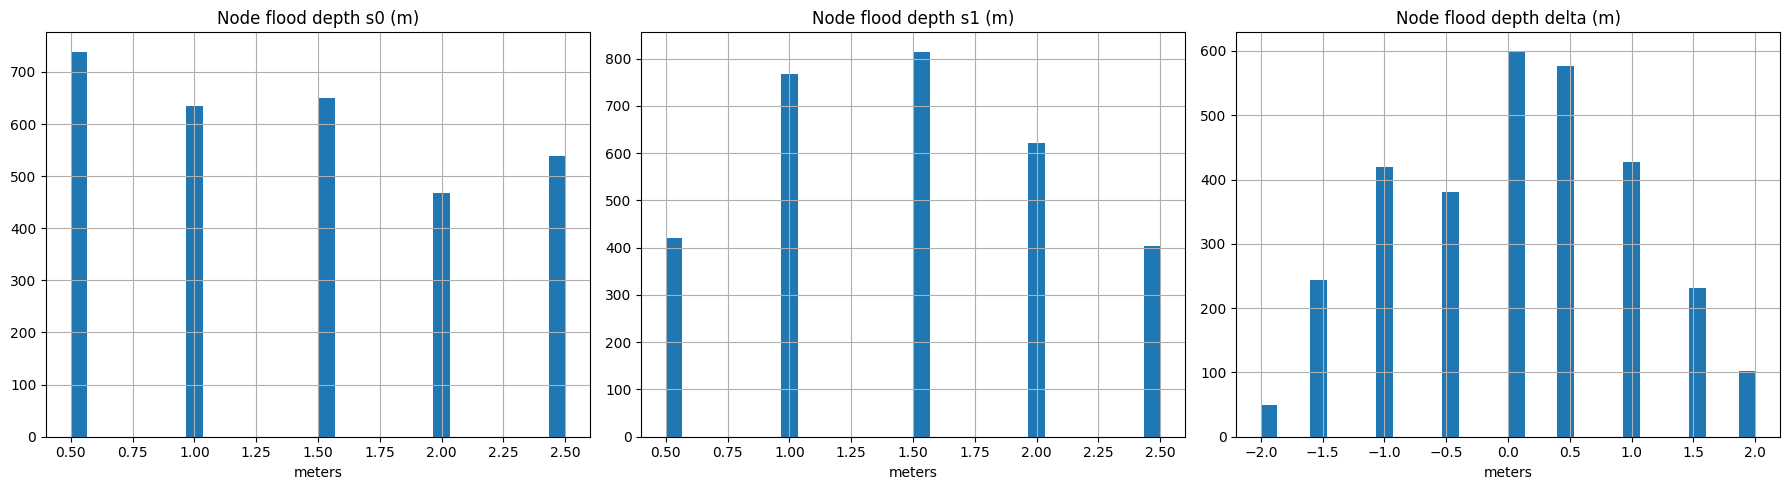

In [231]:
# Quick visuals: flood levels, deltas, and map
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
level_to_depth = {1: 0.5, 2: 1.0, 3: 1.5, 4: 2.0, 5: 2.5}
depth_t1 = nodes_with_flood["flood_level_s0"].map(level_to_depth)
depth_t2 = nodes_with_flood["flood_level_s1"].map(level_to_depth)
delta_depth = depth_t2 - depth_t1

depth_t1.hist(ax=axes[0], bins=30)
axes[0].set_title("Node flood depth s0 (m)")
depth_t2.hist(ax=axes[1], bins=30)
axes[1].set_title("Node flood depth s1 (m)")
delta_depth.hist(ax=axes[2], bins=30)
axes[2].set_title("Node flood depth delta (m)")
for ax in axes:
    ax.set_xlabel("meters")
plt.tight_layout()
plt.show()


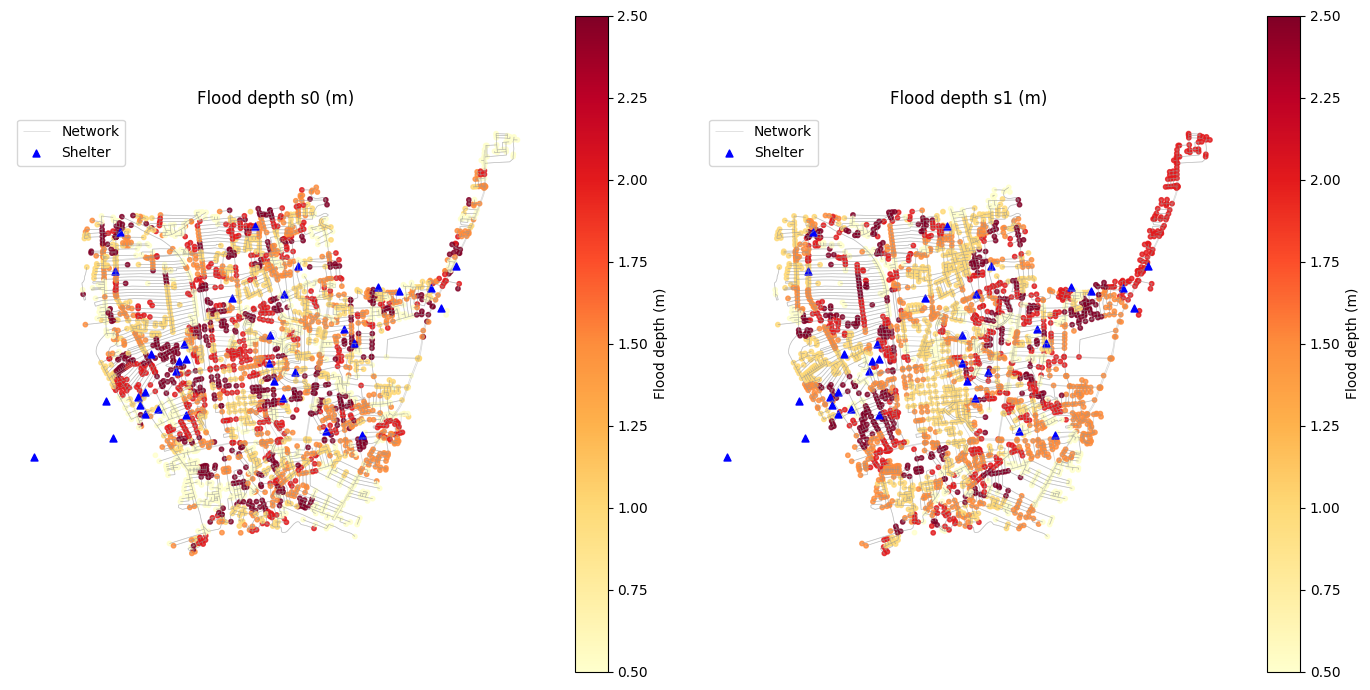

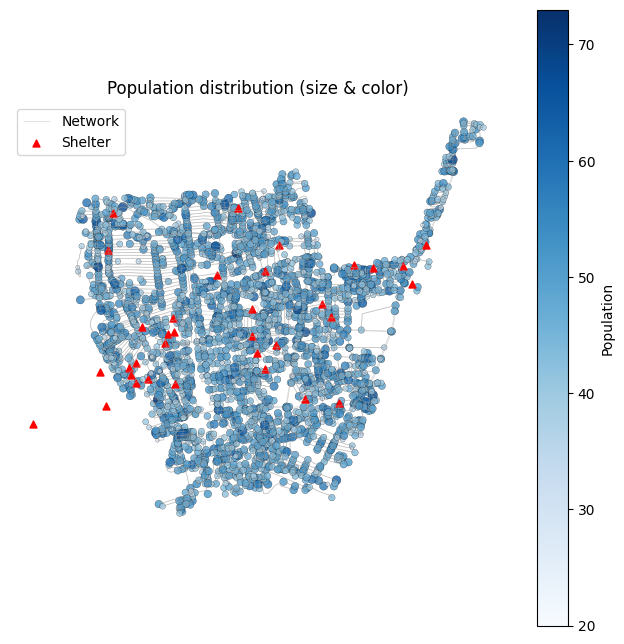

In [232]:
# Maps: separate flood levels (t1, t2) with network, and population colored by size
# Map categorical flood levels to depth in meters
level_to_depth = {1: 0.5, 2: 1.0, 3: 1.5, 4: 2.0, 5: 2.5}
nodes_plot = gpd.GeoDataFrame(
    nodes_with_flood.assign(
        flood_depth_s0_m=nodes_with_flood["flood_level_s0"].map(level_to_depth),
        flood_depth_s1_m=nodes_with_flood["flood_level_s1"].map(level_to_depth),
    ),
    geometry=gpd.points_from_xy(nodes_with_flood.x, nodes_with_flood.y),
    crs="EPSG:4326",
)
edges_geom = (
    ox.graph_to_gdfs(graph_filtered, nodes=False, edges=True)
    .reset_index()[["u", "v", "key", "geometry"]]
)

# Flood depth maps (meters, fixed marker size) + network lines
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
for ax, col, title in zip(
    axes,
    ["flood_depth_s0_m", "flood_depth_s1_m"],
    ["Flood depth s0 (m)", "Flood depth s1 (m)"],
):
    edges_geom.plot(ax=ax, color="#999", linewidth=0.5, alpha=0.4, label="Network")
    nodes_plot.plot(
        ax=ax,
        column=col,
        cmap="YlOrRd",
        markersize=10,
        alpha=0.8,
        legend=True,
        legend_kwds={"label": "Flood depth (m)"},
    )
    shelters.plot(ax=ax, color="blue", markersize=25, marker="^", label="Shelter")
    ax.set_title(title)
    ax.set_axis_off()
    ax.legend()
plt.tight_layout()
plt.show()

# Population map (size and color by pop_total) + network lines
pop_series = nodes_with_flood.get("pop_total")
if pop_series is None:
    pop_series = pd.Series(1, index=nodes_with_flood.index)
pop_norm = (pop_series - pop_series.min()).clip(lower=1)
pop_size = 50 * pop_norm / pop_norm.max()
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
edges_geom.plot(ax=ax, color="#999", linewidth=0.5, alpha=0.4, label="Network")
nodes_plot.plot(
    ax=ax,
    column=pop_series,
    cmap="Blues",
    markersize=pop_size,
    alpha=0.8,
    edgecolor="k",
    linewidth=0.2,
    legend=True,
    legend_kwds={"label": "Population"},
)
shelters.plot(ax=ax, color="red", markersize=25, marker="^", label="Shelter")
ax.set_title("Population distribution (size & color)")
ax.set_axis_off()
ax.legend()
plt.show()

# Flood-aware evacuation parameters and simulation setup

This section defines speed/slowdown assumptions, assigns a travel mode per node, builds a time-expanded graph (t1→t2 by default, configurable), computes a max-flow to shelters, and prepares an animation of network availability under flooding.

In [233]:
# Parameters: speeds, flood slowdown, time steps, and mode assignment (scalable flood snapshots)
import datetime as dt

# Base speeds (km/h). You can tweak per run.
base_speed_kmh = {
    "walk": 5.0,   # walking 4–5 km/h
    "drive": 50.0  # urban driving 40–60 km/h
}

# Flood slowdown factors by level (multiplicative). Levels >= impassable_level drop the edge.
flood_slowdown = {
    0: 1.0,   # dry
    1: 0.5,
    2: 0.2,
    3: 0.0,   # level 3+ impassable by rule below
    4: 0.0,
    5: 0.0,
}
impassable_level = 3

# Time grid: 5-minute steps spanning min/max snapshot timestamps
snapshot_labels = [s["label"] for s in snapshots]
snapshot_times = [pd.to_datetime(s["timestamp"]) for s in snapshots]
snapshot_order = np.argsort(snapshot_times)
snapshot_labels = [snapshot_labels[i] for i in snapshot_order]
snapshot_times = [snapshot_times[i] for i in snapshot_order]

# Use snapshot range unless you want to override manually
# t_start = pd.Timestamp("2025-11-24 22:00:00")
# t_end = pd.Timestamp("2025-11-26 18:00:00")
t_start = snapshot_times[0]
t_end = snapshot_times[-1]
freq = "5min"
time_index = pd.date_range(start=t_start, end=t_end, freq=freq)
time_steps = [
    {"name": f"t{i}", "timestamp": ts}
    for i, ts in enumerate(time_index)
]

# Incremental flood update using interpolation across arbitrary snapshots
level_to_depth = {1: 0.5, 2: 1.0, 3: 1.5, 4: 2.0, 5: 2.5}
depth_to_level = {v: k for k, v in level_to_depth.items()}
depths_sorted = np.array(sorted(depth_to_level.keys()))

# Build depth matrix per edge for each snapshot
edge_depth_matrix = []
for lbl in snapshot_labels:
    edge_depth_matrix.append(edges_with_flood[f"flood_level_{lbl}"].map(level_to_depth).fillna(depths_sorted.min()).to_numpy())
edge_depth_matrix = np.vstack(edge_depth_matrix).T  # shape: (n_edges, n_snapshots)

snapshot_hours = np.array([(ts - t_start).total_seconds() / 3600.0 for ts in snapshot_times])

for i, ts in enumerate(time_index):
    hour = (ts - t_start).total_seconds() / 3600.0
    # Interpolate depth per edge across snapshots (clamped at ends)
    depth_now = np.apply_along_axis(lambda row: np.interp(hour, snapshot_hours, row, left=row[0], right=row[-1]), 1, edge_depth_matrix)
    nearest_depth = depths_sorted[np.abs(depth_now[:, None] - depths_sorted).argmin(axis=1)]
    edges_with_flood[f"flood_level_t{i}"] = pd.Series(nearest_depth).map(depth_to_level)

# Mode choice probabilities (editable). Must sum to 1.
mode_probs = {"walk": 0.4, "drive": 0.6}
mode_labels = list(mode_probs.keys())
mode_weights = np.array(list(mode_probs.values()), dtype=float)
mode_weights = mode_weights / mode_weights.sum()

rng_modes = np.random.default_rng(123)

nodes_modes = nodes_with_flood.copy()
if "mode" not in nodes_modes.columns or nodes_modes["mode"].isna().any():
    nodes_modes["mode"] = rng_modes.choice(mode_labels, size=len(nodes_modes), p=mode_weights)

print(nodes_modes["mode"].value_counts(normalize=True).rename("share"))

/var/folders/wk/qkt4jd3144lcc_q05d6x6h7m0000gn/T/ipykernel_28703/4194536655.py:58: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  edges_with_flood[f"flood_level_t{i}"] = pd.Series(nearest_depth).map(depth_to_level)
/var/folders/wk/qkt4jd3144lcc_q05d6x6h7m0000gn/T/ipykernel_28703/4194536655.py:58: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  edges_with_flood[f"flood_level_t{i}"] = pd.Series(nearest_depth).map(depth_to_level)
/var/folders/wk/qkt4jd3144lcc_q05d6x6h7m0000gn/T/ipykernel_28703/4194536655.py:58: PerformanceWarning: Dat

mode
drive    0.597887
walk     0.402113
Name: share, dtype: float64


/var/folders/wk/qkt4jd3144lcc_q05d6x6h7m0000gn/T/ipykernel_28703/4194536655.py:58: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  edges_with_flood[f"flood_level_t{i}"] = pd.Series(nearest_depth).map(depth_to_level)
/var/folders/wk/qkt4jd3144lcc_q05d6x6h7m0000gn/T/ipykernel_28703/4194536655.py:58: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  edges_with_flood[f"flood_level_t{i}"] = pd.Series(nearest_depth).map(depth_to_level)
/var/folders/wk/qkt4jd3144lcc_q05d6x6h7m0000gn/T/ipykernel_28703/4194536655.py:58: PerformanceWarning: Dat

In [234]:
# Build time-expanded graph and compute max-flow to shelters (nearest-sink via Dijkstra)
from collections import defaultdict
import time

# Helpers (deduplicate osmid to avoid Series-return on .loc)
mode_lookup = nodes_modes.groupby("osmid")["mode"].agg(lambda s: s.iloc[0])
pop_lookup = nodes_modes.groupby("osmid")["pop_total"].sum().fillna(0)
capacity_lookup = nodes_modes.groupby("osmid")["capacity"].max().fillna(1e6)

# Map time names to flood level columns (expects flood_level_<name>)
time_names = [t["name"] for t in time_steps]
time_stamps = [pd.to_datetime(t["timestamp"]) for t in time_steps]

missing_cols = [c for c in [f"flood_level_{n}" for n in time_names] if c not in edges_with_flood.columns]
if missing_cols:
    raise ValueError(f"Missing flood columns in edges_with_flood: {missing_cols}")

# Precompute delta hours between steps
step_hours = [
    (time_stamps[i + 1] - time_stamps[i]).total_seconds() / 3600.0
    for i in range(len(time_stamps) - 1)
]


def edge_speed_kmh(mode: str, flood_level: float) -> float:
    # Driving stops at flood level >= 1 by request
    if mode == "drive" and flood_level >= 1:
        return 0.0
    if flood_level >= impassable_level:
        return 0.0
    factor = flood_slowdown.get(int(flood_level), flood_slowdown.get(0, 1.0))
    return base_speed_kmh.get(mode, 0.0) * factor


def travel_time_hours(length_m: float, speed_kmh: float) -> float:
    if speed_kmh <= 0:
        return np.inf
    return (length_m / 1000.0) / speed_kmh


def build_time_expanded_graph(nodes_df, edges_df):
    t0 = time.time()
    nodes_unique = nodes_df.drop_duplicates(subset=["osmid"])  
    G = nx.DiGraph()
    # Layered nodes
    for ti, name in enumerate(time_names):
        for _, n in nodes_unique.iterrows():
            osmid = int(n["osmid"])
            node_id = (osmid, ti)
            G.add_node(
                node_id,
                time=name,
                mode=mode_lookup.loc[osmid],
                is_shelter=bool(n.get("is_shelter", False)),
                pop=float(pop_lookup.loc[osmid]),
            )
    # Waiting edges
    for ti in range(len(time_names) - 1):
        for _, n in nodes_unique.iterrows():
            osmid = int(n["osmid"])
            node_id_now = (osmid, ti)
            node_id_next = (osmid, ti + 1)
            G.add_edge(
                node_id_now,
                node_id_next,
                capacity=float(capacity_lookup.loc[osmid]),
                travel_hours=step_hours[ti],
                kind="wait",
            )
    # Movement edges (apply flood slowdown/impassable)
    for ti, name in enumerate(time_names[:-1]):
        flood_col = f"flood_level_{name}"
        for _, e in edges_df.iterrows():
            flood_level = e.get(flood_col, 0)
            if pd.isna(flood_level):
                flood_level = 0
            mode_u = mode_lookup.get(e["u"], "walk")
            speed = edge_speed_kmh(mode_u, flood_level)
            if speed <= 0:
                continue
            t_hours = travel_time_hours(e.get("length", 0), speed)
            if t_hours > step_hours[ti]:
                continue  # cannot arrive within next time layer
            G.add_edge(
                (int(e["u"]), ti),
                (int(e["v"]), ti + 1),
                capacity=float(e.get("capacity", 1e6)),
                travel_hours=t_hours,
                kind="move",
                mode=mode_u,
                flood_level=float(flood_level),
            )
    print(f"Time-expanded graph built in {time.time()-t0:.1f}s: nodes={G.number_of_nodes()} edges={G.number_of_edges()}")
    return G


def pick_nearest_shelter_targets(G):
    """Use Dijkstra travel_hours from each origin (t0) to shelters (last layer) to select closest sink per origin.
    Falls back to all shelters if none are reachable."""
    last_layer = len(time_names) - 1
    shelter_targets = [(int(osmid), last_layer) for osmid in nodes_modes.loc[nodes_modes["is_shelter"] == True, "osmid"].drop_duplicates()]
    if not shelter_targets:
        raise ValueError("No shelters found for Dijkstra search.")
    origins = [(int(osmid), 0) for osmid in nodes_modes.loc[nodes_modes["pop_total"] > 0, "osmid"].drop_duplicates()]
    chosen = set()
    unreachable = 0
    for origin in origins:
        dist = nx.single_source_dijkstra_path_length(G, origin, weight="travel_hours")
        reachable = {t: dist[t] for t in shelter_targets if t in dist}
        if not reachable:
            unreachable += 1
            continue
        best_target = min(reachable, key=reachable.get)
        chosen.add(best_target)
    if not chosen:
        print("No shelters reachable via Dijkstra; falling back to all shelters as sinks.")
        chosen = set(shelter_targets)
    if unreachable:
        print(f"Origins with no reachable shelter routes: {unreachable}/{len(origins)} (kept reachable ones)")
    # return only osmids (we will connect all time layers for those osmids)
    return {t[0] for t in chosen}


def run_evacuation_max_flow(G):
    H = G.copy()
    super_source = "super_source"
    super_sink = "super_sink"
    H.add_node(super_source)
    H.add_node(super_sink)

    total_demand = pop_lookup.sum()
    # Inject demand at first layer
    for osmid, pop in pop_lookup.items():
        if pop <= 0:
            continue
        H.add_edge(super_source, (int(osmid), 0), capacity=float(pop))

    # Pick closest sinks via Dijkstra with fallback (osmids only)
    chosen_shelter_osmids = pick_nearest_shelter_targets(G)

    # Connect chosen shelters in ALL time layers to allow early arrival
    for osmid in chosen_shelter_osmids:
        for layer in range(len(time_names)):
            H.add_edge((int(osmid), layer), super_sink, capacity=1e9)

    print(f"Running max-flow on graph with {H.number_of_nodes()} nodes and {H.number_of_edges()} edges...")
    flow_value, flow_dict = nx.maximum_flow(H, super_source, super_sink, capacity="capacity")
    evac_rate = flow_value / total_demand if total_demand > 0 else 0

    # Summaries by shelter
    shelter_flow = defaultdict(float)
    for osmid in chosen_shelter_osmids:
        for layer in range(len(time_names)):
            shelter_flow[int(osmid)] += flow_dict.get((int(osmid), layer), {}).get(super_sink, 0)

    print(f"Total demand: {total_demand:.0f} people")
    print(f"Max-flow evacuated: {flow_value:.0f} people ({evac_rate:.1%} of demand)")
    print("Shelter arrivals (people):")
    for osmid, val in shelter_flow.items():
        print(f"  node {osmid}: {val:.0f}")

    return {
        "flow_value": flow_value,
        "evac_rate": evac_rate,
        "flow_dict": flow_dict,
        "graph": H,
        "shelter_flow": shelter_flow,
    }


t0_build = time.time()
G_te = build_time_expanded_graph(nodes_modes, edges_with_flood)
print(f"Build finished in {time.time()-t0_build:.1f}s")
flow_results = run_evacuation_max_flow(G_te)
print("nodes_unique:", len(nodes_modes.drop_duplicates("osmid")))
print("time layers:", len(time_names))
print("wait edges:", len(nodes_modes.drop_duplicates("osmid")) * (len(time_names)-1))
tmpG = G_te
print("G nodes:", tmpG.number_of_nodes(), "edges:", tmpG.number_of_edges())
move_edges = sum(1 for _,_,d in tmpG.edges(data=True) if d.get("kind") == "move")
print("move edges:", move_edges)
print("chosen shelters:", len(pick_nearest_shelter_targets(tmpG)))


Time-expanded graph built in 181.3s: nodes=1602341 edges=1934705
Build finished in 182.0s
Origins with no reachable shelter routes: 2978/3029 (kept reachable ones)
Running max-flow on graph with 1602343 nodes and 1954662 edges...
Total demand: 140851 people
Max-flow evacuated: 2380 people (1.7% of demand)
Shelter arrivals (people):
  node 1680666752: 54
  node 2505177601: 55
  node 1680667143: 97
  node 2506093960: 63
  node 2506085642: 47
  node 1680666763: 42
  node 2507400717: 33
  node 2507400979: 61
  node 2506087956: 51
  node 13424220827: 42
  node 1680666527: 55
  node 8642279458: 54
  node 1123399595: 41
  node 1680667181: 37
  node 2508580015: 50
  node 4900465967: 55
  node 2506088243: 37
  node 8524034231: 49
  node 1680667329: 137
  node 2507401026: 43
  node 2506085829: 102
  node 2507400902: 193
  node 4900465480: 33
  node 10248233554: 43
  node 1680666455: 40
  node 2507400919: 134
  node 4900465243: 39
  node 2506086755: 225
  node 1680667364: 46
  node 1680666214: 98

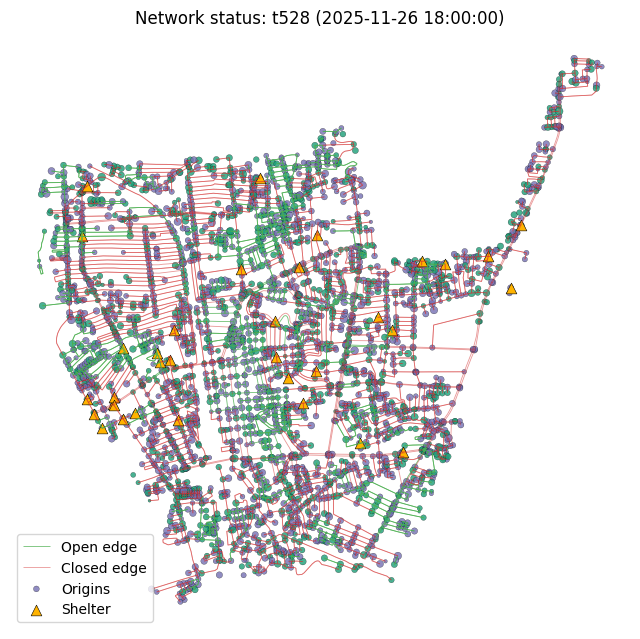

In [235]:
# Animation: network availability and evac movement (red dots flowing from sources to sinks)
from matplotlib.animation import FuncAnimation

# Rebuild geometries for animation
edges_anim = (
    ox.graph_to_gdfs(graph_filtered, nodes=False, edges=True)
    .reset_index()[["u", "v", "key", "geometry"]]
    .merge(
        edges_with_flood[["u", "v", "key"] + [f"flood_level_{n}" for n in time_names]],
        on=["u", "v", "key"],
        how="left",
    )
)

nodes_anim = gpd.GeoDataFrame(
    nodes_modes,
    geometry=gpd.points_from_xy(nodes_modes.x, nodes_modes.y),
    crs="EPSG:4326",
)

mode_colors = {"walk": "#1b9e77", "drive": "#7570b3"}
pop_series = nodes_anim.get("pop_total", pd.Series(1, index=nodes_anim.index))
pop_norm = (pop_series - pop_series.min()).clip(lower=1)
pop_size = 35 * pop_norm / pop_norm.max()

# Precompute edge geometry lookup for movement visualization
geom_lookup = {}
for _, row in edges_anim.iterrows():
    geom_lookup[(int(row.u), int(row.v))] = row.geometry

# Build per-frame agent positions from max-flow move edges
flow_dict = flow_results["flow_dict"]
H_flow = flow_results["graph"]  # includes super source/sink plus move edges
agent_scale = 20 # people per animated dot (smaller -> more dots)
agent_cap = 200      # max dots per edge per frame
agent_positions = [[] for _ in time_names]

for (u, v, data) in H_flow.edges(data=True):
    if data.get("kind") != "move":
        continue
    flow_val = flow_dict.get(u, {}).get(v, 0)
    if flow_val <= 0:
        continue
    ti = u[1]
    if ti >= len(time_names):
        continue
    geom = geom_lookup.get((int(u[0]), int(v[0]))) or geom_lookup.get((int(v[0]), int(u[0])))
    if geom is None:
        continue
    n_agents = int(min(max(flow_val / agent_scale, 1), agent_cap))
    for j in range(n_agents):
        frac = (j + 1) / (n_agents + 1)
        pt = geom.interpolate(frac, normalized=True)
        agent_positions[ti].append((pt.x, pt.y))

if sum(len(f) for f in agent_positions) == 0:
    print("No evac movement to animate (flow is zero on move edges). Check flow_results and parameters.")

fig, ax = plt.subplots(figsize=(8, 8))


def update(frame_idx):
    ax.clear()
    time_name = time_names[frame_idx]
    time_label = time_stamps[frame_idx]
    col = f"flood_level_{time_name}"
    open_mask = edges_anim[col].fillna(0) < impassable_level
    edges_anim[open_mask].plot(ax=ax, color="#4caf50", linewidth=0.6, alpha=0.8, label="Open edge")
    edges_anim[~open_mask].plot(ax=ax, color="#d32f2f", linewidth=0.6, alpha=0.5, label="Closed edge")
    nodes_anim.plot(
        ax=ax,
        color=nodes_anim["mode"].map(mode_colors),
        markersize=pop_size,
        alpha=0.8,
        edgecolor="k",
        linewidth=0.2,
        label="Origins",
    )
    nodes_anim[nodes_anim["is_shelter"] == True].plot(
        ax=ax,
        color="#ffb300",
        markersize=60,
        marker="^",
        edgecolor="k",
        linewidth=0.4,
        label="Shelter",
    )
    # Moving evac dots for this frame
    if agent_positions[frame_idx]:
        xs, ys = zip(*agent_positions[frame_idx])
        ax.scatter(xs, ys, color="#e53935", s=35, alpha=0.9, label="Evac flow")
    ax.set_title(f"Network status: {time_name} ({time_label})")
    ax.set_axis_off()
    handles, labels = ax.get_legend_handles_labels()
    uniq = dict(zip(labels, handles))
    ax.legend(uniq.values(), uniq.keys(), loc="lower left")
    return ax

ani = FuncAnimation(fig, update, frames=len(time_names), interval=800, repeat=True)


# Optional: save GIF (commented to keep runs fast; requires pillow)
ani.save("data/clean/evac_animation.gif", writer="pillow", fps=2)
plt.show()
